<a href="https://colab.research.google.com/github/rezendervp/chemical-engineering/blob/main/DMD_Exemplo_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exemplo de Aplicação do Algoritimo DMD em Python
Dynamic Mode Decomposition

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv
from scipy.linalg import svd, svdvals
from scipy.integrate import odeint, ode, complex_ode
from warnings import warn


Criando padrões espaço-temporais distintos
Estes modos são usado para formar um padrão mais complexo que será usado para a decomposição
O objetivo é obter os Modos ou Padrões principais (que devem ser iguais ou muito similares aos  modos criados), e enão reconstruir o Padrão complexo, dado pela soma dos modos identificados.

In [2]:
# define time and space domains
x = np.linspace(-10, 10, 100)
t = np.linspace(0, 6*pi, 200)
dt = t[2] - t[1]
Xm,Tm = np.meshgrid(x, t)

# create three spatiotemporal patterns
f1 = multiply(20-0.2*power(Xm, 2), exp((2.3j)*Tm))
f2 = multiply(Xm, exp(0.6j*Tm))
f3 = multiply(5*multiply(1/cosh(Xm/2), tanh(Xm/2)), 2*exp((0.1+2.8j)*Tm))

# combine signals and make data matrix
D = (f1 + f2 + f3).T
# create DMD input-output matrices
X = D[:,:-1]    #todas as colunas exceto a última
Y = D[:,1:]     #todas as colunas a partir da 2a   -> defasagem de 1 índice entre X e Y, ouseja, observaç~loes separadas por dt.

Abaixo, podemos vizualizar os Padrões criados e o Padrão final composto.

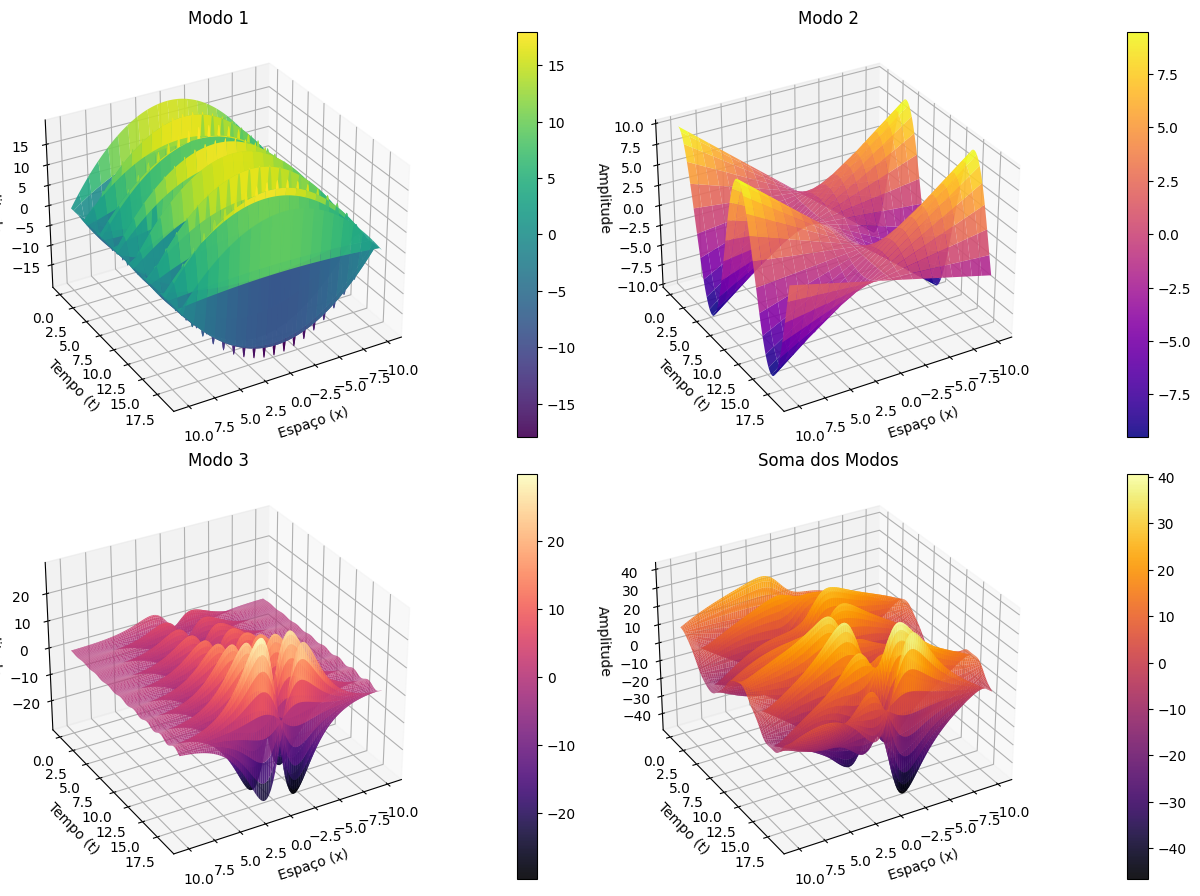

In [3]:
# Padrão 1
fig = plt.figure(figsize=(16, 9))

# Padrão 1 - Original
ax1 = fig.add_subplot(221, projection='3d')
surf1 = ax1.plot_surface(Xm, Tm, np.real(f1), cmap='viridis', alpha=0.9, rstride=5, cstride=5, linewidth=0, antialiased=True)
ax1.set_title('Modo 1')
ax1.set_xlabel('Espaço (x)')
ax1.set_ylabel('Tempo (t)')
ax1.set_zlabel('Amplitude')
fig.colorbar(surf1, ax=ax1, pad=0.1)

# Padrão 2 - Original
ax2 = fig.add_subplot(222, projection='3d')
surf2 = ax2.plot_surface(Xm, Tm, np.real(f2), cmap='plasma', alpha=0.9, rstride=5, cstride=5, linewidth=0, antialiased=True)
ax2.set_title('Modo 2')
ax2.set_xlabel('Espaço (x)')
ax2.set_ylabel('Tempo (t)')
ax2.set_zlabel('Amplitude')
fig.colorbar(surf2, ax=ax2, pad=0.1)

# Padrão 3 - Original
ax3 = fig.add_subplot(223, projection='3d')
surf3 = ax3.plot_surface(Xm, Tm, np.real(f3), cmap='magma', alpha=0.9, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax3.set_title('Modo 3')
ax3.set_xlabel('Espaço (x)')
ax3.set_ylabel('Tempo (t)')
ax3.set_zlabel('Amplitude')
fig.colorbar(surf3, ax=ax3, pad=0.1)

# Matriz D
ax_d = fig.add_subplot(224, projection='3d')
surf_d = ax_d.plot_surface(Xm, Tm, np.real(D).T, cmap='inferno', alpha=0.9, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax_d.set_title('Soma dos Modos')
ax_d.set_xlabel('Espaço (x)')
ax_d.set_ylabel('Tempo (t)')
ax_d.set_zlabel('Amplitude')
fig.colorbar(surf_d, ax=ax_d, pad=0.1)

# Ajuste da iluminação para suavizar as sombras
for ax in [ax1, ax2, ax3, ax_d]:
    ax.view_init(elev=30, azim=60)  # Ajuste os ângulos conforme necessário
plt.subplots_adjust(hspace=5)
plt.tight_layout()


plt.show()

Em seguida, fazemos a decomposição em valores Singulares

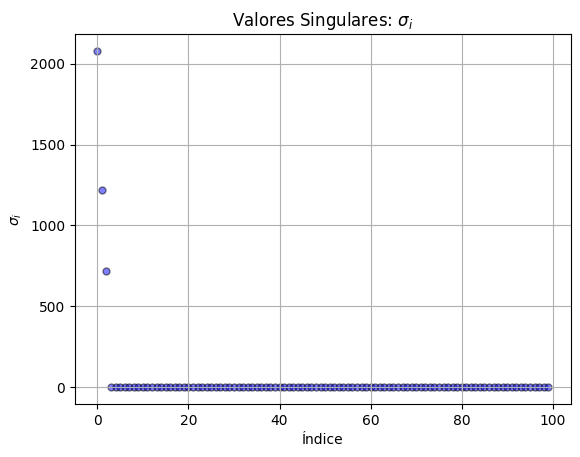

In [4]:
# SVD of input matrix
U2,Sig2,Vh2 = svd(X, False)
plt.scatter(range(len(Sig2)), Sig2, color='blue',alpha=0.5,s=25,edgecolors = 'black')
plt.title('Valores Singulares: '+ r'$\sigma_{i}$')
plt.xlabel('Índice')
plt.ylabel(r'$\sigma_{i}$')
plt.grid(True)
plt.show()

Pelo Gráfico acima, os 3 primeiros valores singulares são muito mais dominates quando comparado aos demais

In [5]:
# rank-3 truncation
r = 3
U = U2[:,:r]
Sig = diag(Sig2)[:r,:r]
V = Vh2.conj().T[:,:r]

# build A tilde
Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig))
mu,W = eig(Atil)


Verificando a distribuíção dos autovalores no plano complexo. O ideal é que estejam o mais próximo possível do círculo demarcado. E é o que se pode ver abaixo:





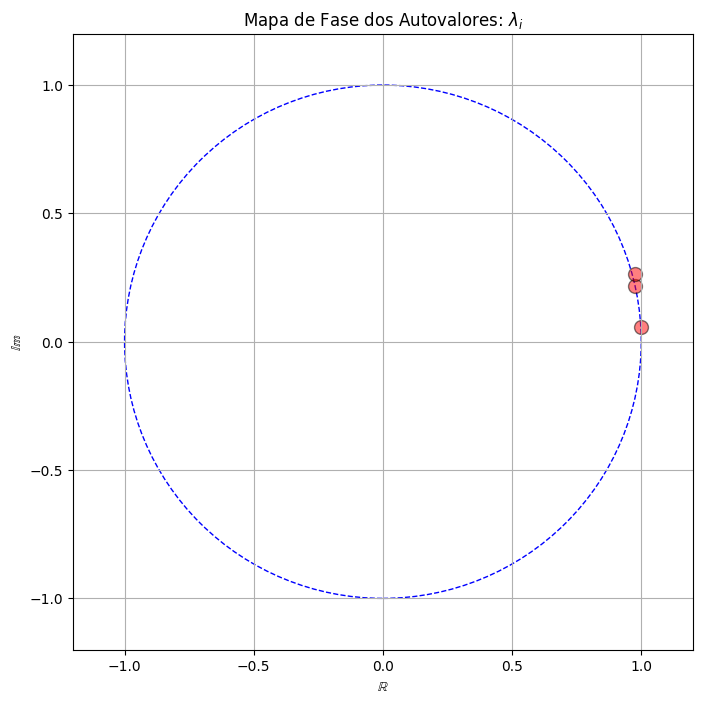

In [9]:
# Criar um mapa de fase dos autovalores com um círculo centrado na origem
plt.figure(figsize=(8, 8))

# Definir os limites dos eixos
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

# Adicionar um círculo centrado na origem
circle = plt.Circle((0, 0), 1, edgecolor='blue', facecolor='none', linestyle='dashed', linewidth=1)
plt.gca().add_patch(circle)

# Criar o gráfico de dispersão dos autovalores
plt.scatter(np.real(mu), np.imag(mu), color='red', marker='o',alpha=0.5, s=100,edgecolors = 'black')

# Configurações do gráfico
plt.title('Mapa de Fase dos Autovalores: ' + r'$\lambda_{i}$')
plt.xlabel(r'$\mathbb{R}$')
plt.ylabel(r'$\mathbb{Im}$')
plt.grid(True)

# Mostrar o gráfico
plt.show()

Cada autovalor ecoa no comportamento dinâmico de seu modo DMD correspondente.
  * Se o autovalor tiver uma parte imaginária *diferente de zero*, ***então há oscilação*** no modo DMD correspondente.
  * Se o autovalor estiver dentro do círculo unitário (parte real e imaginária menor do 1) , então o Modo está decaindo;
  * Se o autovalor estiver fora ( parte imaginária e/ou real maior do que 1), então o Modo está crescendo.  
  * Se o autovalor cair **exatamente** no círculo unitário, então o modo não cresce nem decai. Ele fica em um ciclo estável.

  Observando o Gráfico acima, todos os autovalores possuem parte imaginária, logo, os Modos correspondentes oscilam no tempo. Além disto, há dois deles eexatamente sobre o círculo unitário (ciclos estáveis), e um deles fora ligeiramente, indicando que há uma tendência a aumentar sua amplitude no tempo, ou seja, ele ficará cada vez mais intenso aumentando sua magnitude.



In [7]:
# build DMD modes

#Phi = [(Y.V).inv(Sigma)].W  -> vári9os porudots escalares entre viversas matrizes

Phi = dot(dot(dot(Y, V), inv(Sig)), W)

Os modos rpncipais (r=3) foram extraídos do conjunto de dados. Agora podemos ver seu comportamento

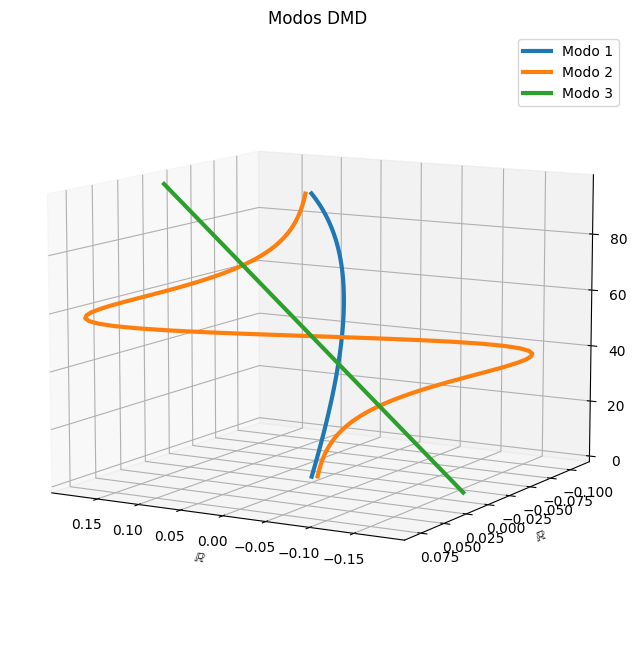

In [10]:
# Plotar os modos DMD em um gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotar cada modo como uma linha
for i in range(Phi.shape[1]):
    ax.plot(np.real(Phi[:, i]), np.imag(Phi[:, i]), range(len(Phi)), label=f'Modo {i + 1}',linewidth=3)

# Configurações do gráfico
# Configurações do gráfico
ax.set_title('Modos DMD')
ax.set_xlabel(r'$\mathbb{R}$')  # Símbolo LaTeX para 'Parte Real'
ax.set_ylabel(r'$\mathbb{R}$')  # Símbolo LaTeX para 'Parte Imaginária'
ax.set_zlabel(r'$\mathrm{Tempo}$')  # Símbolo LaTeX para 'Tempo'
ax.legend()

# Ajustar a vista (elevação, azimute)
ax.view_init(elev=10, azim=120)

# Mostrar o gráfico
plt.show()

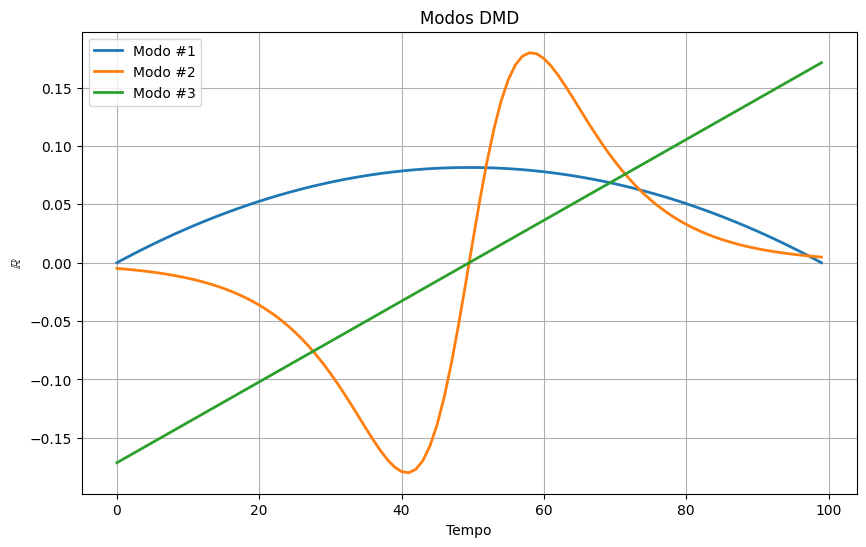

In [11]:
# Plotar a parte real dos modos DMD em um gráfico 2D
plt.figure(figsize=(10, 6))

# Plotar cada modo como uma linha
for i in range(Phi.shape[1]):
    plt.plot(range(len(Phi)), np.real(Phi[:, i]), label=f'Modo #{i + 1}',linewidth=2)

# Configurações do gráfico
plt.title('Modos DMD')
plt.xlabel('Tempo')
plt.ylabel(r'$\mathbb{R}$')
plt.legend()
plt.grid(True)




# Mostrar o gráfico
plt.show()

Estes perfis representam as estruturas coerentes dominantes que evoluem no tempo. Cada um deles é uma coluna da Matriz $\Phi$.
Podemos então computar sua evolução no tempo.

In [12]:
# compute time evolution
b = dot(pinv(Phi), X[:,0])
Psi = np.zeros([r, len(t)], dtype='complex')
for i,_t in enumerate(t):
    Psi[:,i] = multiply(power(mu, _t/dt), b)

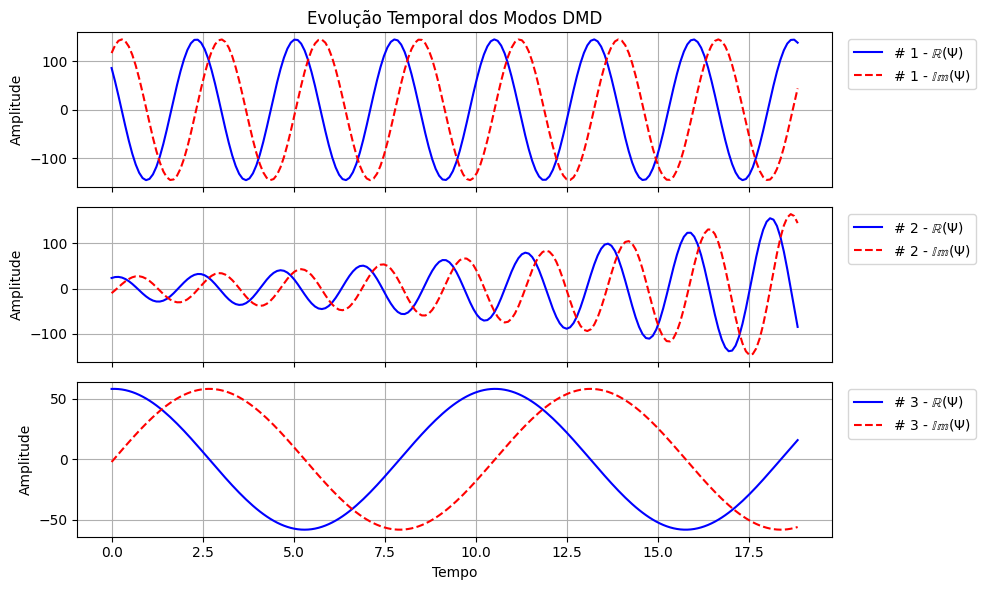

In [13]:
# Plotar a evolução temporal de cada modo em subplots empilhados
fig, axs = plt.subplots(r, 1, figsize=(10, 2*r), sharex=True)


for mode_index in range(r):
    axs[mode_index].plot(t, np.real(Psi[mode_index, :]), label=f'# {mode_index + 1} - ' + r'$\mathbb{R}\left(\Psi\right)$', c = 'blue')
    axs[mode_index].plot(t, np.imag(Psi[mode_index, :]), label=f'# {mode_index + 1} - ' + r'$\mathbb{Im}\left(\Psi\right)$', linestyle='--',c = 'red')

    # Configurações individuais de cada subplot
    axs[mode_index].set_ylabel('Amplitude')
    axs[mode_index].legend(bbox_to_anchor=(1.2, 1),loc='upper right')
     # Adicionar grade
    axs[mode_index].grid(True)


# Configuração global do gráfico
axs[-1].set_xlabel('Tempo')
axs[0].set_title('Evolução Temporal dos Modos DMD')



# Ajustar layout para evitar sobreposição de rótulos de eixos
plt.tight_layout()

# Mostrar o gráfico

plt.show()


Temos então todos os Modos principais (r=3) dos dados Podemos proceder à reconstrução do conjunto orinigal (Matriz de dados D)

In [14]:
# compute DMD reconstruction
D2 = dot(Phi, Psi)
np.allclose(D, D2) # True

True

E em seguida proceder com a plotagem dos resultados.

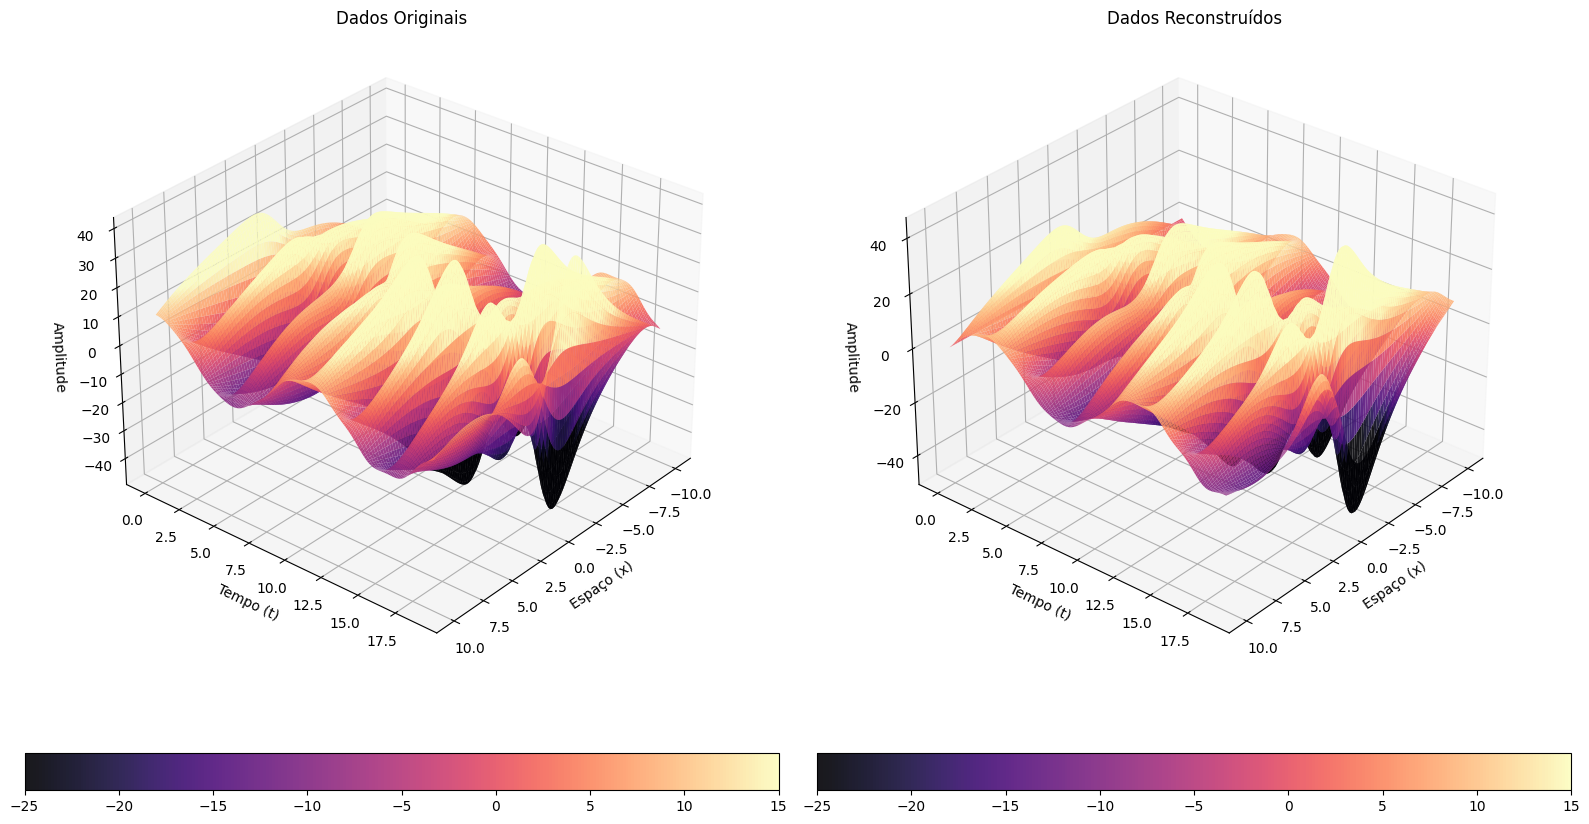

In [18]:
# Criar duas figuras lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), subplot_kw={'projection': '3d'})

# Primeira figura
surf1 = ax1.plot_surface(Xm, Tm, np.real(D).T, cmap='magma', alpha=0.9, rstride=1, cstride=1, linewidth=0, antialiased=True,vmin=-25, vmax=15)
ax1.set_title('Dados Originais')
ax1.set_xlabel('Espaço (x)')
ax1.set_ylabel('Tempo (t)')
ax1.set_zlabel('Amplitude')
fig.colorbar(surf1, ax=ax1, pad=0.1,orientation='horizontal')

# Segunda figura
surf2 = ax2.plot_surface(Xm, Tm, np.imag(D2).T, cmap='magma', alpha=0.9, rstride=1, cstride=1, linewidth=0, antialiased=True,vmin=-25, vmax=15)
ax2.set_title('Dados Reconstruídos')
ax2.set_xlabel('Espaço (x)')
ax2.set_ylabel('Tempo (t)')
ax2.set_zlabel('Amplitude')
fig.colorbar(surf2, ax=ax2, pad=0.1,orientation='horizontal')

# Ajuste da iluminação para suavizar as sombras
for ax in [ax1, ax2]:
    ax.view_init(elev=30, azim=40)  # Ajuste os ângulos conforme necessário
plt.subplots_adjust(hspace=5)


# Ajustar layout
plt.tight_layout()

# Mostrar as figuras
plt.show()

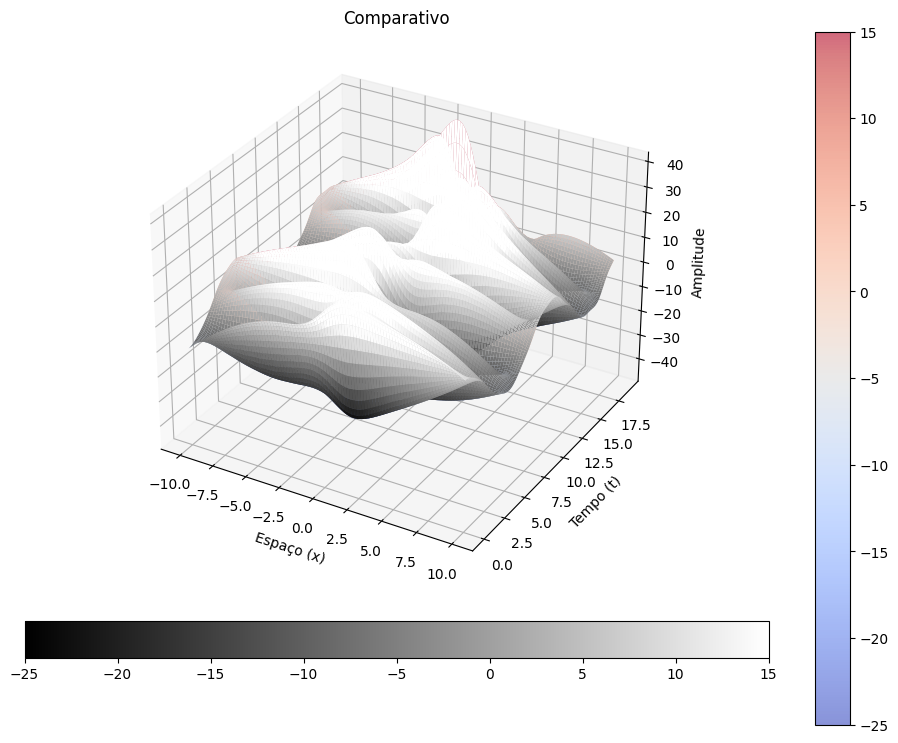

In [17]:
# Criação da figura e do subplot 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plotagem do primeiro conjunto de dados (D) - opaco
surf1 = ax.plot_surface(Xm, Tm, np.real(D).T, cmap='coolwarm', alpha=0.6, rstride=1, cstride=1, linewidth=0, antialiased=True, vmin=-25, vmax=15)

# Plotagem do segundo conjunto de dados (D2) - com alpha menor
surf2 = ax.plot_surface(Xm, Tm, np.real(D2).T, cmap='gray', alpha=1.0, rstride=1, cstride=1, linewidth=0, antialiased=True, vmin=-25, vmax=15)

# Configurações do subplot 3D
ax.set_title('Comparativo')
ax.set_xlabel('Espaço (x)')
ax.set_ylabel('Tempo (t)')
ax.set_zlabel('Amplitude')
ax.view_init(elev=30, azim=-60)

# Adiciona uma barra de cores na horizontal
fig.colorbar(surf1, ax=ax, orientation='vertical', pad=0.05)
fig.colorbar(surf2, ax=ax, orientation='horizontal', pad=0.05)

# Mostrar o gráfico
plt.show()

A diferença absoluta entre estes dois conjuntos de dados, pode ser vista diretamente abaixo. Note que a escala é da ordem de 1e-12. Estas diferenças são sensíveis a taxa de amostragem, ou seja, ao passo de tempo.

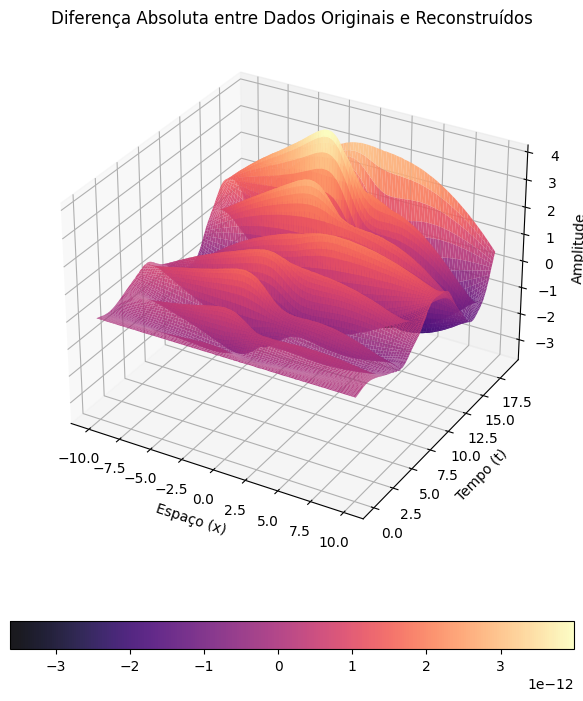

In [19]:
D_diff = D-D2;


fig = plt.figure(figsize=(16, 9))

# Primeiro gráfico (Parte Real)
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(Xm, Tm, np.real(D_diff).T, cmap='magma', alpha=0.9, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax1.set_title('Diferença Absoluta entre Dados Originais e Reconstruídos')
ax1.set_xlabel('Espaço (x)')
ax1.set_ylabel('Tempo (t)')
ax1.set_zlabel('Amplitude')
fig.colorbar(surf1, ax=ax1, pad=0.1, orientation ='horizontal')

Abaixo, temos o mapa de congtorno da difenrecá absoluta normalizada pelo valor máximo absoluto das diferenças entre os a reconstrução e os dados originais.

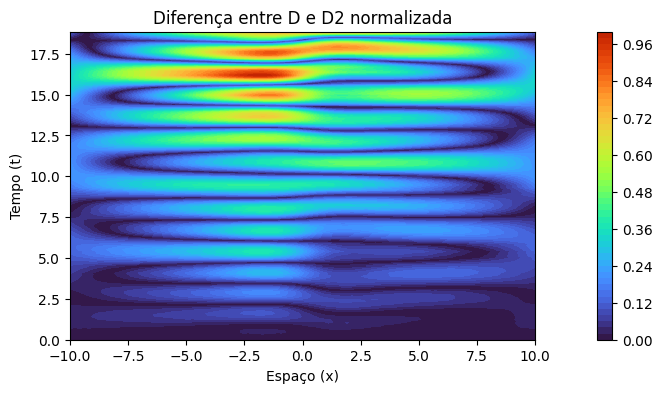

In [20]:
# Calcular a diferença entre D e D2
D_diff = np.real(D) - np.real(D2)
D_diff_norm =np.abs(D_diff)/np.max(abs(D_diff))
D_diff_norm

import numpy as np
import matplotlib.pyplot as plt

# Seus dados anteriores...

# Calcular a diferença entre D e D2
D_diff = np.real(D) - np.real(D2)

# Criar a figura e o subplot do mapa de contorno
fig, ax = plt.subplots(figsize=(8, 4))

# Plotar o mapa de contorno da diferença
contour = ax.contourf(Xm, Tm, D_diff_norm.T, cmap='turbo', levels=51, vmin=0, vmax=1.1)

# Adicionar barra de cores
fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.1)

# Adicionar rótulos, títulos, etc.
ax.set_title('Diferença entre D e D2 normalizada')
ax.set_xlabel('Espaço (x)')
ax.set_ylabel('Tempo (t)')

# Mostrar o gráfico
plt.show()





Agora podemos comparar os 3 modos obtidos pela decomposição com os modos exatos gerados no início para fim de comparação.

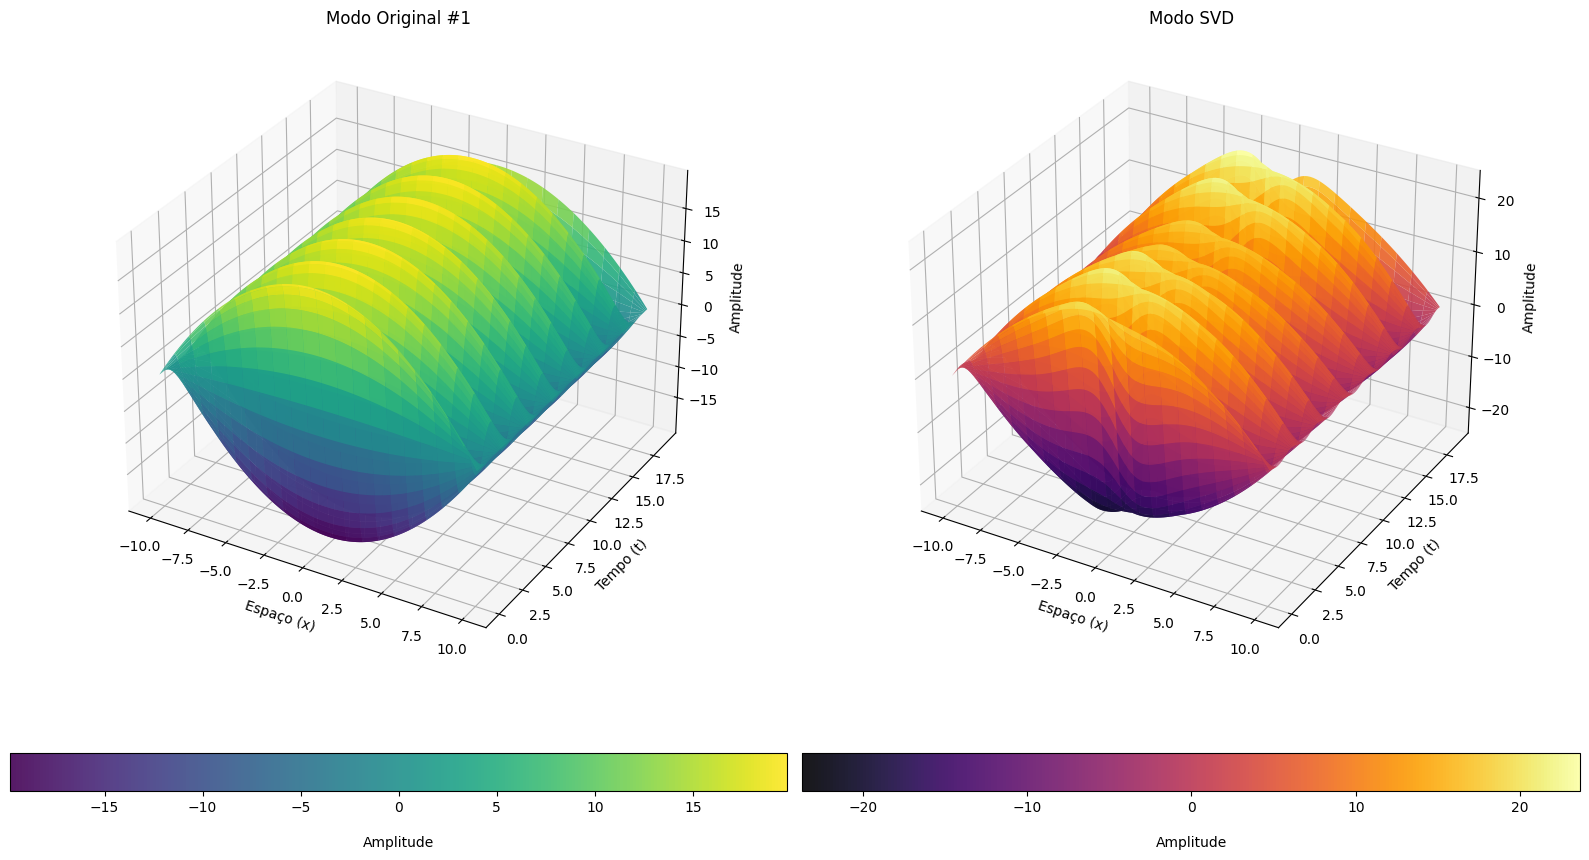

In [65]:
# Obter o primeiro modo usando a matriz U, Sigma, e Vh
modo1 = np.dot(U2[:, 0][:, np.newaxis] * Sig2[0], Vh2[0, :][np.newaxis, :])

# Criar subplot 3D para o primeiro modo
fig = plt.figure(figsize=(16, 9))
ax_original = fig.add_subplot(121, projection='3d')  # Subplot para o modo original
ax_decomposto = fig.add_subplot(122, projection='3d')  # Subplot para o modo decomposto

# Ajustar o tamanho do modo1
Xm_aux = Xm[:-1, :]  # Manter apenas as primeiras 199 colunas
Tm_aux = Tm[:-1, :]  # Manter apenas as primeiras 199 colunas

# Plotar a superfície do modo original
surf_original = ax_original.plot_surface(Xm, Tm, np.real(f1), cmap='viridis', alpha=0.9, rstride=1, cstride=5, linewidth=1, antialiased=True)
ax_original.set_title('Modo Original #1')
ax_original.set_xlabel('Espaço (x)')
ax_original.set_ylabel('Tempo (t)')
ax_original.set_zlabel('Amplitude')
cbar_original = fig.colorbar(surf_original, ax=ax_original, pad=0.1, orientation = 'horizontal')
cbar_original.set_label('Amplitude', rotation=0, labelpad=15)

# Plotar a superfície do modo obtido pela decomposição
surf_decomposto = ax_decomposto.plot_surface(Xm_aux, Tm_aux, np.real(modo1.T), cmap='inferno', alpha=0.9, rstride=1, cstride=5, linewidth=1, antialiased=True)
ax_decomposto.set_title('Modo SVD')
ax_decomposto.set_xlabel('Espaço (x)')
ax_decomposto.set_ylabel('Tempo (t)')
ax_decomposto.set_zlabel('Amplitude')
# Adicionar barra de cores para o subplot decomposto
cbar_decomposto = fig.colorbar(surf_decomposto, ax=ax_decomposto, pad=0.1,orientation ='horizontal')
cbar_decomposto.set_label('Amplitude', rotation=0, labelpad=15)


# Ajustes de layout
fig.tight_layout()
plt.grid(True)

# Mostrar o gráfico
plt.show()

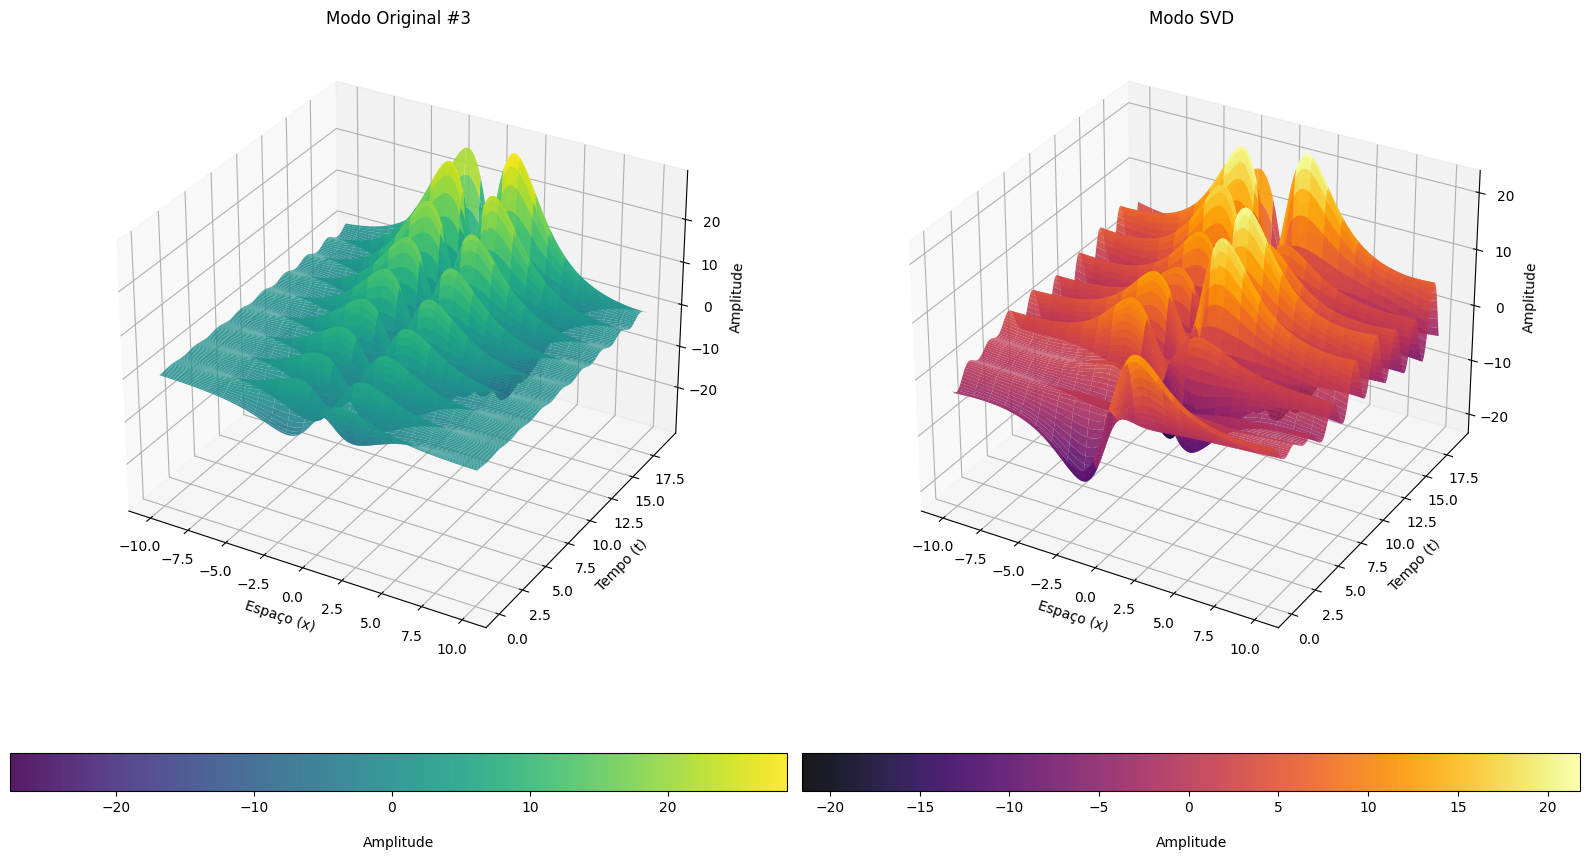

In [63]:
# Obter o segundo  modo usando a matriz U, Sigma, e Vh
#####################################################
# este modo coincide com o modo f3. Eles não sao necessarimente ordenados da mesma forma, isrto depende dos SVD's
###########################################################################

modo2 = np.dot(U2[:, 1][:, np.newaxis] * Sig2[1], Vh2[1, :][np.newaxis, :])

# Criar subplot 3D para o primeiro modo
fig = plt.figure(figsize=(16, 9))
ax_original = fig.add_subplot(121, projection='3d')  # Subplot para o modo original
ax_decomposto = fig.add_subplot(122, projection='3d')  # Subplot para o modo decomposto

# Ajustar o tamanho do modo1
Xm_aux = Xm[:-1, :]  # Manter apenas as primeiras 199 colunas
Tm_aux = Tm[:-1, :]  # Manter apenas as primeiras 199 colunas

# Plotar a superfície do modo original
surf_original = ax_original.plot_surface(Xm, Tm, np.real(f3), cmap='viridis', alpha=0.9, rstride=1, cstride=5, linewidth=1, antialiased=True)
ax_original.set_title('Modo Original #3')
ax_original.set_xlabel('Espaço (x)')
ax_original.set_ylabel('Tempo (t)')
ax_original.set_zlabel('Amplitude')
cbar_original = fig.colorbar(surf_original, ax=ax_original, pad=0.1, orientation = 'horizontal')
cbar_original.set_label('Amplitude', rotation=0, labelpad=15)

# Plotar a superfície do modo obtido pela decomposição
surf_decomposto = ax_decomposto.plot_surface(Xm_aux, Tm_aux, np.real(modo2.T), cmap='inferno', alpha=0.9, rstride=1, cstride=5, linewidth=1, antialiased=True)
ax_decomposto.set_title('Modo SVD')
ax_decomposto.set_xlabel('Espaço (x)')
ax_decomposto.set_ylabel('Tempo (t)')
ax_decomposto.set_zlabel('Amplitude')
# Adicionar barra de cores para o subplot decomposto
cbar_decomposto = fig.colorbar(surf_decomposto, ax=ax_decomposto, pad=0.1,orientation ='horizontal')
cbar_decomposto.set_label('Amplitude', rotation=0, labelpad=15)


# Ajustes de layout
fig.tight_layout()
plt.grid(True)

# Mostrar o gráfico
plt.show()

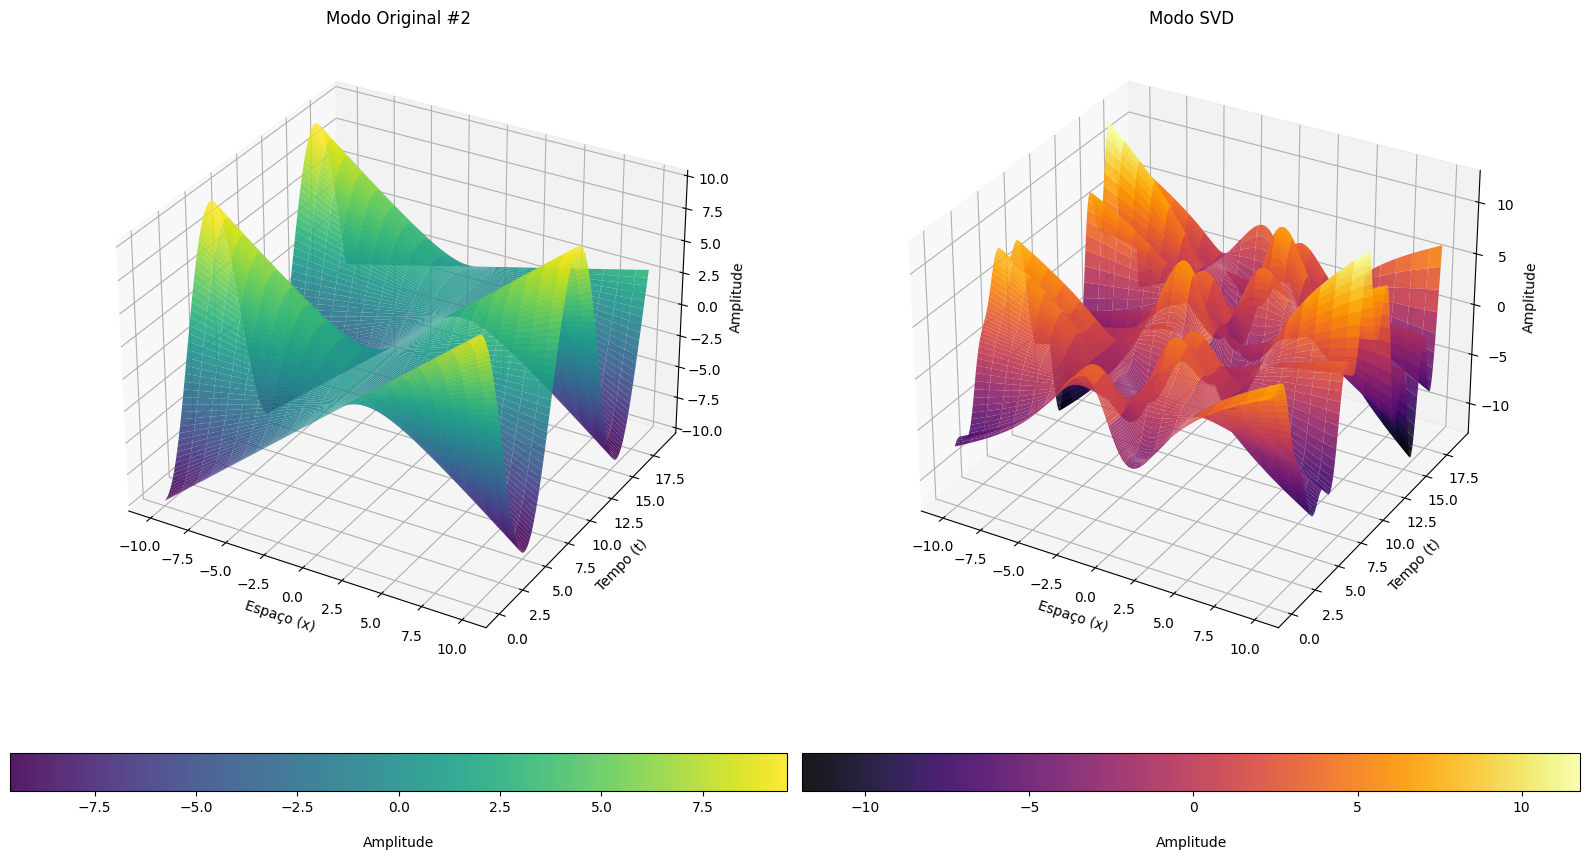

In [64]:
# Obter o primeiro modo usando a matriz U, Sigma, e Vh
modo3 = np.dot(U2[:, 2][:, np.newaxis] * Sig2[2], Vh2[2, :][np.newaxis, :])

# Criar subplot 3D para o primeiro modo
fig = plt.figure(figsize=(16, 9))
ax_original = fig.add_subplot(121, projection='3d')  # Subplot para o modo original
ax_decomposto = fig.add_subplot(122, projection='3d')  # Subplot para o modo decomposto

# Ajustar o tamanho do modo1
Xm_aux = Xm[:-1, :]  # Manter apenas as primeiras 199 colunas
Tm_aux = Tm[:-1, :]  # Manter apenas as primeiras 199 colunas

# Plotar a superfície do modo original
surf_original = ax_original.plot_surface(Xm, Tm, np.real(f2), cmap='viridis', alpha=0.9, rstride=1, cstride=5, linewidth=1, antialiased=True)
ax_original.set_title('Modo Original #2')
ax_original.set_xlabel('Espaço (x)')
ax_original.set_ylabel('Tempo (t)')
ax_original.set_zlabel('Amplitude')
cbar_original = fig.colorbar(surf_original, ax=ax_original, pad=0.1, orientation = 'horizontal')
cbar_original.set_label('Amplitude', rotation=0, labelpad=15)

# Plotar a superfície do modo obtido pela decomposição
surf_decomposto = ax_decomposto.plot_surface(Xm_aux, Tm_aux, np.real(modo3.T), cmap='inferno', alpha=0.9, rstride=1, cstride=5, linewidth=1, antialiased=True)
ax_decomposto.set_title('Modo SVD')
ax_decomposto.set_xlabel('Espaço (x)')
ax_decomposto.set_ylabel('Tempo (t)')
ax_decomposto.set_zlabel('Amplitude')
# Adicionar barra de cores para o subplot decomposto
cbar_decomposto = fig.colorbar(surf_decomposto, ax=ax_decomposto, pad=0.1,orientation ='horizontal')
cbar_decomposto.set_label('Amplitude', rotation=0, labelpad=15)


# Ajustes de layout
fig.tight_layout()
plt.grid(True)

# Mostrar o gráfico
plt.show()

Isto demosntra a capacidade de decomposiçào e reconstrução da abordagem SVD.